In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, roc_auc_score
# Imported from Professor Demos

In [109]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [110]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
y = pd.Series(y.values.ravel(), name="target")
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [111]:
print(X)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

# Data Cleaning

In [112]:
cat_imputer = SimpleImputer(strategy="most_frequent")
X.loc[:,"thal"] = cat_imputer.fit_transform(X[["thal"]])
cat_imputer = SimpleImputer(strategy="most_frequent")
X.loc[:,"ca"] = cat_imputer.fit_transform(X[["ca"]])
print(X) 

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

### Addressing noisy/inconsistent data

In this data set a lot of the categorical data is encoded as an integer which might make our model order these values when they should 
have no order to them (patient dependent). In the next part, I will work on feature engineering where I aim to sort out the categorical variables

In [113]:
categorical_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
encoder = OneHotEncoder(sparse_output=False, drop='first')

one_hot_encoded = encoder.fit_transform(X[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

X_encoded = pd.concat([X, one_hot_df], axis=1)
X_encoded = X_encoded.drop(categorical_columns, axis=1)
print(X_encoded.head())
# Source: https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/

   age  trestbps  chol  thalach  oldpeak   ca  sex_1  cp_2  cp_3  cp_4  fbs_1  \
0   63       145   233      150      2.3  0.0    1.0   0.0   0.0   0.0    1.0   
1   67       160   286      108      1.5  3.0    1.0   0.0   0.0   1.0    0.0   
2   67       120   229      129      2.6  2.0    1.0   0.0   0.0   1.0    0.0   
3   37       130   250      187      3.5  0.0    1.0   0.0   1.0   0.0    0.0   
4   41       130   204      172      1.4  0.0    0.0   1.0   0.0   0.0    0.0   

   restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  
0        0.0        1.0      0.0      0.0      1.0       1.0       0.0  
1        0.0        1.0      1.0      1.0      0.0       0.0       0.0  
2        0.0        1.0      1.0      1.0      0.0       0.0       1.0  
3        0.0        0.0      0.0      0.0      1.0       0.0       0.0  
4        0.0        1.0      0.0      0.0      0.0       0.0       0.0  


In [114]:
from sklearn.preprocessing import StandardScaler

#Chat GPT recommended to only standardize the continous features because binary features are intuitive to the
# audience receiving it (doctors/nurses/med professionals)
scaler = StandardScaler()
std = scaler.fit_transform(X_encoded)

print("Standardized (mean=0, std=1):\n", pd.DataFrame(std, columns=X_encoded.columns))

Standardized (mean=0, std=1):
           age  trestbps      chol   thalach   oldpeak        ca     sex_1  \
0    0.948726  0.757525 -0.264900  0.017197  1.087338 -0.711131  0.686202   
1    1.392002  1.611220  0.760415 -1.821905  0.397182  2.504881  0.686202   
2    1.392002 -0.665300 -0.342283 -0.902354  1.346147  1.432877  0.686202   
3   -1.932564 -0.096170  0.063974  1.637359  2.122573 -0.711131  0.686202   
4   -1.489288 -0.096170 -0.825922  0.980537  0.310912 -0.711131 -1.457296   
..        ...       ...       ...       ...       ...       ...       ...   
298 -1.046013 -1.234430  0.334813 -0.770990  0.138373 -0.711131  0.686202   
299  1.502821  0.700612 -1.038723 -0.376896  2.036303  1.432877  0.686202   
300  0.283813 -0.096170 -2.238149 -1.515388  0.138373  0.360873  0.686202   
301  0.283813 -0.096170 -0.206864  1.068113 -0.896862  0.360873 -1.457296   
302 -1.821745  0.359134 -1.386944  1.024325 -0.896862 -0.711131  0.686202   

         cp_2      cp_3      cp_4     fbs_1 

# Model Training and Evaluation

## Gaussian NB without Smoothing

Accuracy: 0.8241758241758241
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        49
           1       0.77      0.88      0.82        42

    accuracy                           0.82        91
   macro avg       0.83      0.83      0.82        91
weighted avg       0.83      0.82      0.82        91



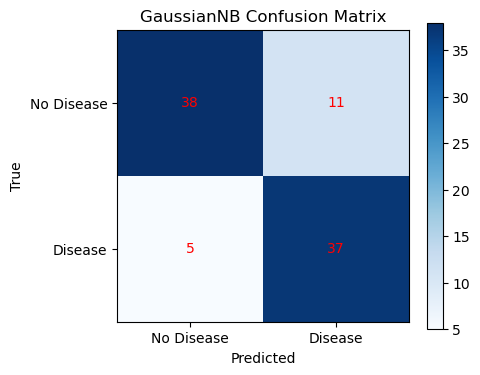

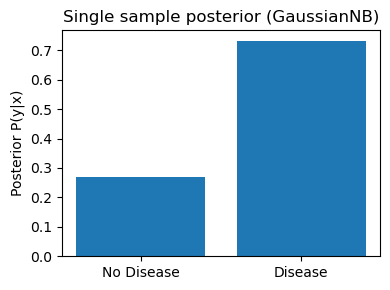

In [115]:
y_binary = (y > 0).astype(int) 
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.3, random_state=42, stratify=y
)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0,1], ["No Disease","Disease"])
plt.yticks([0,1], ["No Disease","Disease"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GaussianNB Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()

idx = 0
plt.figure(figsize=(4,3))
plt.bar([0,1], y_proba[idx])
plt.xticks([0,1], ["No Disease","Disease"])
plt.ylabel("Posterior P(y|x)")
plt.title("Single sample posterior (GaussianNB)")
plt.tight_layout()
plt.show()

## Linear Regression 

LinearRegression (0/1) accuracy: 0.763

Classification report (Linear Regression):
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        40
           1       0.80      0.67      0.73        36

    accuracy                           0.76        76
   macro avg       0.77      0.76      0.76        76
weighted avg       0.77      0.76      0.76        76



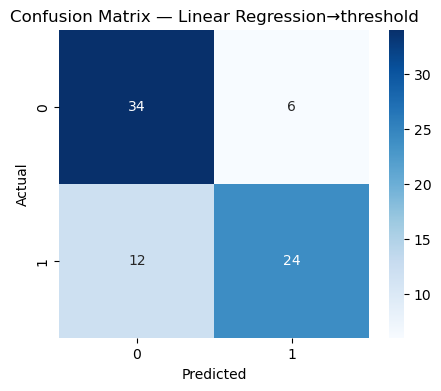

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.25, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)            

score_lr = lr.predict(X_test)       

yhat_lr = (score_lr >= 0.5).astype(int)

print("LinearRegression (0/1) accuracy:", round(accuracy_score(y_test, yhat_lr), 3))
print("\nClassification report (Linear Regression):\n", classification_report(y_test, yhat_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, yhat_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Linear Regression→threshold")
plt.show()

### Ridge Regression vs. Lasso

Ridge Regression (0/1) accuracy: 0.763

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        40
           1       0.80      0.67      0.73        36

    accuracy                           0.76        76
   macro avg       0.77      0.76      0.76        76
weighted avg       0.77      0.76      0.76        76



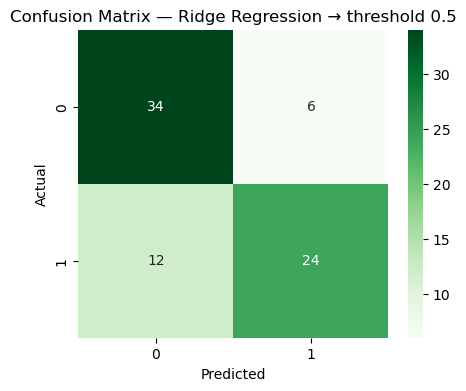

Lasso Regression (0/1) accuracy: 0.763

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80        40
           1       0.82      0.64      0.72        36

    accuracy                           0.76        76
   macro avg       0.78      0.76      0.76        76
weighted avg       0.77      0.76      0.76        76



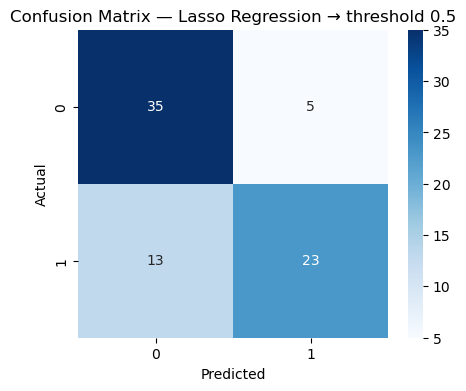

In [118]:
ridge = Ridge(alpha=1.0)  # you can tune alpha with RidgeCV
ridge.fit(X_train, y_train)

# Predict continuous output
y_score = ridge.predict(X_test)

# Threshold to get binary predictions
y_pred = (y_score >= 0.5).astype(int)

# Evaluate
print("Ridge Regression (0/1) accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred))
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Ridge Regression → threshold 0.5")
plt.show()

lasso = Lasso(alpha=0.01, max_iter=10000)  # alpha can be tuned with LassoCV
lasso.fit(X_train, y_train)

# Predict continuous output
y_score = lasso.predict(X_test)

# Convert to binary predictions with threshold 0.5
y_pred = (y_score >= 0.5).astype(int)

# Evaluate
print("Lasso Regression (0/1) accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Lasso Regression → threshold 0.5")
plt.show()